In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


### Get Data

In [11]:
df_test = pd.read_csv('audio_data7_spec_test.csv',low_memory=False)
df_test = df_test[df_test["breed"].notna()]

df_train = pd.read_csv('audio_data7_spec_train.csv',low_memory=False)
df_train = df_train[df_train["breed"].notna()]

In [12]:
# Extract MFCC feature columns
X_test = df_test.iloc[:,5:].values
X_train = df_train.iloc[:,5:].values


# Convert labels to numeric numbers 
# #AUDIO DATA 2
#animal_labels = {"frog": 0, "donkey": 1, "cat": 2, "monkey": 3, "baby sheep": 4, "bird": 5, "lion": 6, "cow": 7, "dog": 8, "chicken": 9}
bird_labels = {"wood_warbler": 0,"barn_swallow": 1,"meadow_pipit": 2,"common_wood_pigeon": 3,"marsh_warbler": 4,"common_house_martin": 5,"african_pied_wagtail": 6,"common_chiffchaff": 7,"common_moorhen": 8,"northern_lapwing": 9,"european_robin": 10,"dunnock": 11,"european_greenfinch": 12,"goldcrest": 13,"corn_bunting": 14,"great_spotted_woodpecker": 15,"red-throated_loon": 16,"european_green_woodpecker": 17,"eurasian_wryneck": 18,"eurasian_collared_dove": 19,"redwing": 20,"willow_tit": 21,"dunlin": 22,"common_redpoll": 23,"tawny_owl": 24,"eurasian_wren": 25,"eurasian_treecreeper": 26,"eurasian_skylark": 27,"common_redshank": 28,"eurasian_coot": 29,"grey_plover": 30,"black_woodpecker": 31,"grey_partridge": 32,"stock_dove": 33,"nan": 34,"western_jackdaw": 35,"rook": 36,"marsh_tit": 37,"yellowhammer": 38,"great_tit": 39,"european_nightjar": 40,"european_bee-eater": 41,"long-tailed_tit": 42,"european_golden_plover": 43,"common_redstart": 44,"garden_warbler": 45,"common_linnet": 46,"tree_pipit": 47,"common_swift": 48,"common_nightingale": 49,"river_warbler": 50,"willow_ptarmigan": 51,"european_goldfinch": 52,"european_herring_gull": 53,"common_pheasant": 54,"song_thrush": 55,"common_blackbird": 56,"western_yellow_wagtail": 57,"eurasian_tree_sparrow": 58,"house_sparrow": 59,"canada_goose": 60,"carrion_crow": 61,"common_chaffinch": 62,"eurasian_bullfinch": 63,"european_turtle_dove": 64,"red_crossbill": 65,"northern_raven": 66,"common_cuckoo": 67,"spotted_flycatcher": 68,"lesser_whitethroat": 69,"eurasian_oystercatcher": 70,"sedge_warbler": 71,"eurasian_magpie": 72,"european_honey_buzzard": 73,"rock_dove": 74,"eurasian_blackcap": 75,"common_reed_bunting": 76,"black-headed_gull": 77,"coal_tit": 78,"eurasian_reed_warbler": 79,"eurasian_golden_oriole": 80,"common_snipe": 81,"willow_warbler": 82,"eurasian_nuthatch": 83,"eurasian_jay": 84,"common_whitethroat": 85,"wood_sandpiper": 86,"eurasian_blue_tit": 87,"common_starling": 88}

y_train = df_train["breed"].map(bird_labels).values
y_test = df_test["breed"].map(bird_labels).values


# # Assign bird species labels (only for bird samples)
# df_train["breed_label"] = df_train.apply(
#     lambda row: bird_labels.get(row["breed"], -1) if row["label"] == "bird" else -1, axis=1
# )
# df_test["breed_label"] = df_test.apply(
#     lambda row: bird_labels.get(row["breed"], -1) if row["label"] == "bird" else -1, axis=1
# )

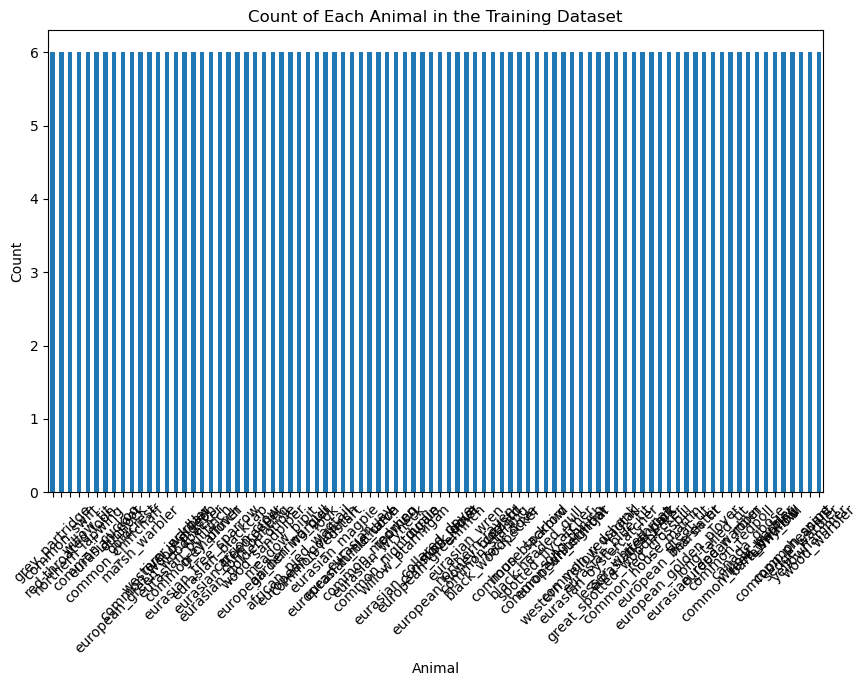

In [13]:
label_counts = df_train['breed'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Count of Each Animal in the Training Dataset')
plt.xticks(rotation=45)
plt.show()

In [14]:
count_mfcc = (X_train.shape[1])
print(X_train.shape)
def reshape_mfcc_for_lstm(mfcc_vector, max_time_steps=13, n_mfcc=count_mfcc):
    if mfcc_vector is None or len(mfcc_vector) == 0:
        print("Warning: Empty MFCC vector encountered, replacing with zeros.")
        return np.zeros((max_time_steps, n_mfcc), dtype=np.float32)

    mfcc_vector = np.array(mfcc_vector, dtype=np.float32)  # Ensure it's a NumPy array

    # Replace any NaN values in the input MFCC vector
    mfcc_vector = np.nan_to_num(mfcc_vector)

    # Ensure it's at least 2D (num_time_steps, n_mfcc)
    if mfcc_vector.ndim == 1:
        if n_mfcc > 0 and len(mfcc_vector) % n_mfcc == 0:
            mfcc_vector = mfcc_vector.reshape(-1, n_mfcc)  # Reshape if mistakenly 1D
        else:
            print("Warning: MFCC vector has incorrect shape, reshaping to default.")
            mfcc_vector = np.zeros((max_time_steps, n_mfcc), dtype=np.float32)

    # Pad or truncate the sequence to a fixed length
    num_time_steps = mfcc_vector.shape[0]
    
    if num_time_steps < max_time_steps:
        pad_width = max_time_steps - num_time_steps
        mfcc_vector = np.pad(mfcc_vector, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc_vector = mfcc_vector[:max_time_steps, :]  # Truncate if too long

    return mfcc_vector  # Shape: (max_time_steps, n_mfcc)

# Ensure all samples are reshaped correctly
X_train = np.array([reshape_mfcc_for_lstm(x) for x in X_train], dtype=np.float32)
X_test = np.array([reshape_mfcc_for_lstm(x) for x in X_test], dtype=np.float32)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Print shapes to verify
print("X_train_tensor shape:", X_train_tensor.shape)  # Expected: (batch_size, max_time_steps, n_mfcc)
print("X_test_tensor shape:", X_test_tensor.shape)  # Expected: (batch_size, max_time_steps, n_mfcc)
print("y_train_tensor shape:", y_train_tensor.shape)  # Expected: (batch_size,)
print("y_test_tensor shape:", y_test_tensor.shape)  # Expected: (batch_size,)

(528, 12800)
X_train_tensor shape: torch.Size([528, 13, 12800])
X_test_tensor shape: torch.Size([88, 13, 12800])
y_train_tensor shape: torch.Size([528])
y_test_tensor shape: torch.Size([88])


In [15]:
# Define Dataset class
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)  # Number of samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = MFCCDataset(X_train_tensor, y_train_tensor)
test_dataset = MFCCDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Create Model

In [16]:
class AudioLSTM(nn.Module):
    def __init__(self, n_mfcc=33, hidden_size=33, num_layers=3, num_classes=89, dropout=0.2):
        super(AudioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(n_mfcc, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)  # Using num_classes_animal for classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step output
        return out


### Initialize Model ###

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioLSTM(n_mfcc=count_mfcc, hidden_size=60, num_layers=2, num_classes=89).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train Model

In [24]:
num_epochs = 50
model.train()
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for inputs, targets in train_loader:
        if torch.isnan(inputs).any():
            print("NaN detected in inputs!")
        if torch.isnan(targets).any():
            print("NaN detected in targets!")
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print("NaN loss detected! Stopping training.")
            break
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    
    # Evaluate on test set
    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct_test / total_test
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

print("Training Complete")
print(f"Final Training Accuracy: {train_accuracy:.2f}%")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")



Epoch [1/50], Train Loss: 4.4952, Train Acc: 0.95%, Test Loss: 4.4910, Test Acc: 1.14%
Epoch [2/50], Train Loss: 4.4923, Train Acc: 0.95%, Test Loss: 4.4898, Test Acc: 0.00%
Epoch [3/50], Train Loss: 4.4894, Train Acc: 0.95%, Test Loss: 4.4877, Test Acc: 1.14%
Epoch [4/50], Train Loss: 4.4714, Train Acc: 1.33%, Test Loss: 4.4681, Test Acc: 1.14%
Epoch [5/50], Train Loss: 4.3849, Train Acc: 2.84%, Test Loss: 4.4844, Test Acc: 2.27%
Epoch [6/50], Train Loss: 4.2641, Train Acc: 1.70%, Test Loss: 4.5714, Test Acc: 0.00%
Epoch [7/50], Train Loss: 4.1919, Train Acc: 2.08%, Test Loss: 4.6639, Test Acc: 0.00%
Epoch [8/50], Train Loss: 4.1271, Train Acc: 2.84%, Test Loss: 4.5613, Test Acc: 3.41%
Epoch [9/50], Train Loss: 4.0400, Train Acc: 3.79%, Test Loss: 4.5764, Test Acc: 2.27%
Epoch [10/50], Train Loss: 3.9580, Train Acc: 4.36%, Test Loss: 4.6186, Test Acc: 2.27%
Epoch [11/50], Train Loss: 3.9283, Train Acc: 3.41%, Test Loss: 4.6494, Test Acc: 1.14%
Epoch [12/50], Train Loss: 3.8416, Train 

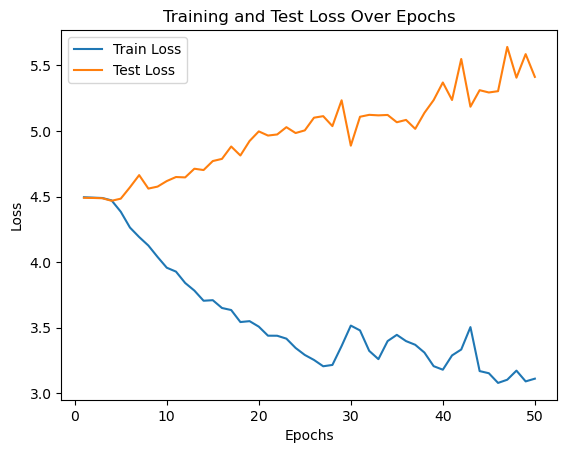

In [25]:
# Plot training and test loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss Over Epochs')
plt.show()


In [28]:
# Evaluate the model on the test set
model.eval()
all_preds, all_labels = [], []
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Define the path where you want to save the model
model_save_path = "final_model_RNN_birdspec.pth"
torch.save(model, model_save_path)
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        
# # Compute the confusion matrix
# cm = confusion_matrix(all_labels, all_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["frog","donkey","cat","monkey","baby sheep","bird","lion","cow","dog","chicken"])

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))  # Increase the figure size
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')

# # Rotate the x-axis labels
# plt.xticks(rotation=45)

# plt.show()

f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
print(f'Weighted F1 Score: {f1:.4f}')

Weighted F1 Score: 0.0246


# Iterating Hyperparameters #

In [73]:
def full_model_evaluation(input_size, hidden_size, output_size, num_layers, training_loops):
    # Instantiate the RNN model
    model = SimpleRNN(input_size, hidden_size, output_size, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            # inputs = inputs.squeeze(1)
            outputs = model(inputs)
            # outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
    
    print("Training complete!")
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"{(hidden_size, num_layers)}Test Accuracy: {accuracy}")
    return accuracy


In [74]:
test_accuracy = dict()
for hidden_size in range(15,46, 3): #ADJUST AS NEEDED
    for num_layers in range(1, 11): #ADJUST AS NEEDED
        model_accuracy = full_model_evaluation(input_size, hidden_size, output_size, num_layers, 100)
        test_accuracy[(hidden_size, num_layers)] = model_accuracy
print("ALL DONE")

NameError: name 'input_size' is not defined

In [49]:
best = max(test_accuracy, key=test_accuracy.get)
print("Best result is", best)
print(test_accuracy[best])
#BEST RESULT FOR DATASET 1 IS (33 hidden features, 10 layers)
#39, 5
#BEST RESULT FOR DATASET 2 IS (30 hidden features, 5 layers) = 0.8392857142857143

Best result is (39, 5)
0.8214285714285714
